# Prerequisites

In [ ]:
# Needed for dataset
!pip install tensorflow-datasets

In [1]:
# Disable tensorflow warnings to clean up cell output
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import keras
from keras.applications import imagenet_utils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow_datasets as tfds
from keras.optimizers import RMSprop

In [3]:
# Needed to remove warnings left over after the above log level is set
# Ref: https://github.com/keras-team/keras-cv/issues/291
tf.get_logger().setLevel('ERROR')

# Create model

In [4]:
# Set random seed for deterministic behavior
keras.utils.set_random_seed(1999)

Use MobileNetV3 as the model to do transfer learning. Chosen due to being one of the best performers in terms of ImageNet accuracy vs. speed of inferencing on a mobile device.

In [5]:
# References:
# https://keras.io/api/applications/#usage-examples-for-image-classification-models
# https://keras.io/guides/transfer_learning/

# Need to explicitly specify input shape as it will default to (None, None, 3) otherwise => becomes (1, 1, 3)
# Use preprocessing layer for MobileNetV5 as MLKit will pass in the input as values between [0, 255]
# Don't include the classifier at the top
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(224, 224, 3), include_preprocessing=True, include_top=False)
# Freeze the model
base_model.trainable = False

# Create new model on top of base model
# Use a simple top layer (trains better than original top layer on dataset)
num_classes = 196 # 196 classes in dataset
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
# Add dropout for regularization
x = keras.layers.Dropout(0.2)(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

Show a summary of the model:

In [6]:
#model.summary()

# Load dataset

In [7]:
# We split test dataset (approx the same size of the train dataset) between validation and test.
# Assume that the sets will be roughly equally stratified, as the original dataset is not ordered by label and there are many classes.
# Return data in (img, label) tuples
(ds_train_orig, ds_validation_orig, ds_test_orig), ds_info = tfds.load('cars196', split=['train', 'test[50%:]', 'test[:50%]'], shuffle_files=True, as_supervised=True, with_info=True)

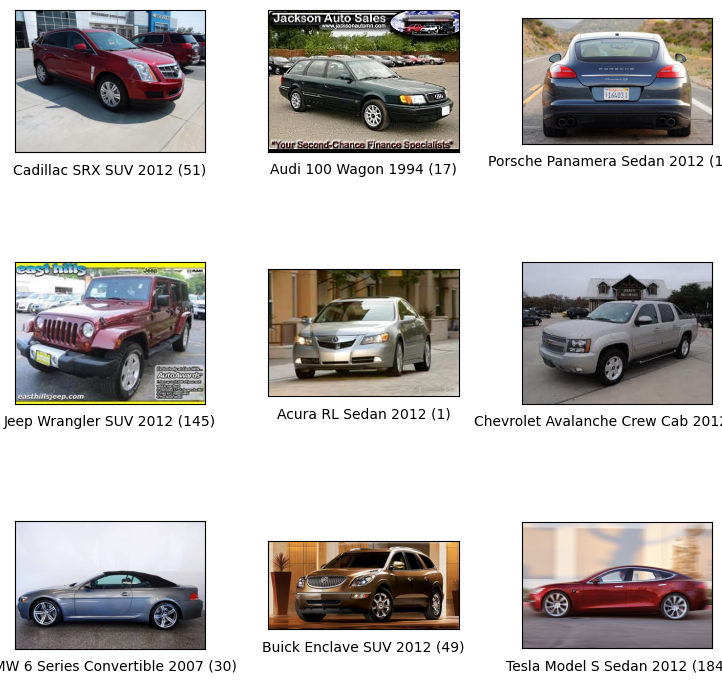

In [8]:
fig = tfds.show_examples(ds_train_orig, ds_info)

Write out class names for use in TFLite:

In [9]:
label_map_text = '\n'.join(ds_info.features['label'].names)
label_map_file = 'cars196_label_map.txt'
with open(label_map_file, 'w') as f:
    f.write(label_map_text)

Save off a sample image for testing in TFLite:

In [10]:
image, label = next(iter(ds_train_orig))
img_path = "example.png"
keras.utils.save_img(img_path, image)
print("Saved image to {}".format(img_path))
print("Label: {} ({})".format(ds_info.features['label'].int2str(label), label))

Saved image to example.png
Label: Cadillac SRX SUV 2012 (51)


## Training pipeline

In [11]:
# Apply data augmentation as part of model (based on https://www.tensorflow.org/tutorials/images/data_augmentation)
IMG_SIZE=224
resize = keras.Sequential([keras.layers.Resizing(IMG_SIZE, IMG_SIZE)], name="Resize")
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1, fill_mode="nearest"),
    ],
    name="DataAugmentation"
)

In [12]:
# Based off of https://www.tensorflow.org/datasets/keras_example

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32), label

# TFDS returns data in uint8 while our model wants float32
ds_train = ds_train_orig.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# Resize data
ds_train = ds_train.map(lambda x, y: (resize(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# Don't cache if system RAM is small
#ds_train = ds_train.cache()
# Batch for each epoch (minimal batching)
ds_train = ds_train.batch(2)
# Apply data augmentation to dataset (slow, as it uses CPU during training)
ds_train = ds_train.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
# Prefetch for performance
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_validation = ds_validation_orig.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# Resize data
ds_validation = ds_validation.map(lambda x, y: (resize(x), y), num_parallel_calls=tf.data.AUTOTUNE)
#ds_validation = ds_validation.cache()
ds_validation = ds_validation.batch(2)
ds_validation = ds_validation.prefetch(tf.data.AUTOTUNE)

## Check how the data augmentation changes the data

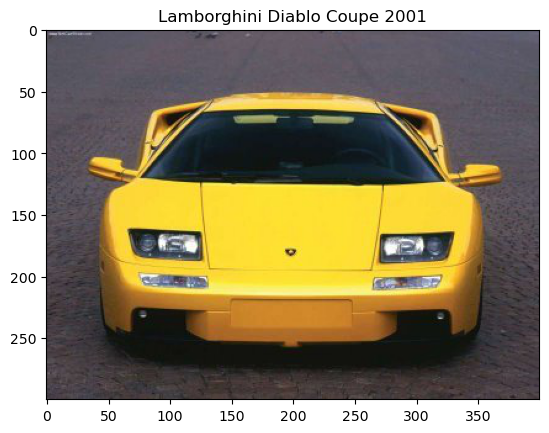

In [13]:
image, label = next(iter(ds_train_orig))
_ = plt.imshow(image)
_ = plt.title(ds_info.features['label'].int2str(label))

In [14]:
# Add image to batch
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

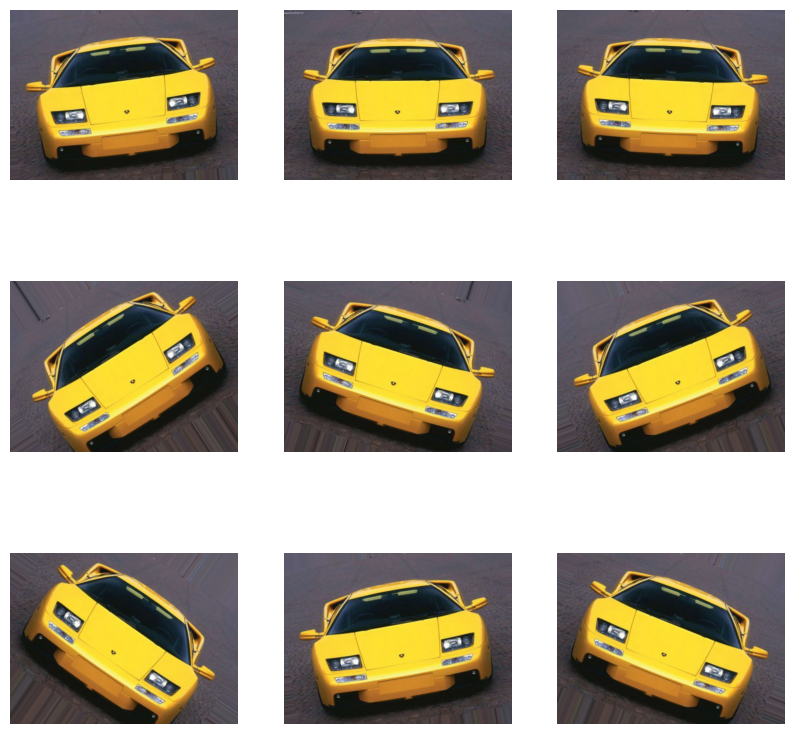

In [15]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image, training=True)
    ax = plt.subplot(3, 3, i + 1)
    # Cast back to integer for pyplot to show correctly
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.axis("off")

## Evaluation pipeline

In [16]:
# Also based off of https://www.tensorflow.org/datasets/keras_example
ds_test = ds_test_orig.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# Resize data
ds_test = ds_test.map(lambda x, y: (resize(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# Don't cache if system RAM is small
#ds_test = ds_test.cache()
ds_test = ds_test.batch(2)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Train the top layer

In [17]:
# Use the RMSProp optimizer as done in the MobileNetV3 paper (trains better than Adam)
# Loss should be what makes sense for multi-class image classification
# We want the sparse version as the provided labels are integers rather than a one-hot representation
# Include accuracy metric so we can see how the predictions perform
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Stop when accuracy on validation set stops increasing (early stopping)
epochs = 100
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.005, patience=3, restore_best_weights=True)
history = model.fit(ds_train, epochs=epochs, validation_data=ds_validation, callbacks=[callback])

Epoch 1/100
4072/4072 [==============================] - 53s 12ms/step - loss: 5.9992 - accuracy: 0.0867 - val_loss: 4.5730 - val_accuracy: 0.1741
Epoch 2/100
4072/4072 [==============================] - 48s 12ms/step - loss: 4.7217 - accuracy: 0.2084 - val_loss: 4.2898 - val_accuracy: 0.2410
Epoch 3/100
4072/4072 [==============================] - 47s 12ms/step - loss: 4.3333 - accuracy: 0.2743 - val_loss: 4.2523 - val_accuracy: 0.2569
Epoch 4/100
4072/4072 [==============================] - 48s 12ms/step - loss: 4.1924 - accuracy: 0.3028 - val_loss: 4.2443 - val_accuracy: 0.2788
Epoch 5/100
4072/4072 [==============================] - 47s 12ms/step - loss: 3.9246 - accuracy: 0.3434 - val_loss: 4.1326 - val_accuracy: 0.3054
Epoch 6/100
4072/4072 [==============================] - 47s 12ms/step - loss: 3.8506 - accuracy: 0.3653 - val_loss: 4.1357 - val_accuracy: 0.3166
Epoch 7/100
4072/4072 [==============================] - 47s 12ms/step - loss: 3.8085 - accuracy: 0.3830 - val_loss: 4

## Learning curves

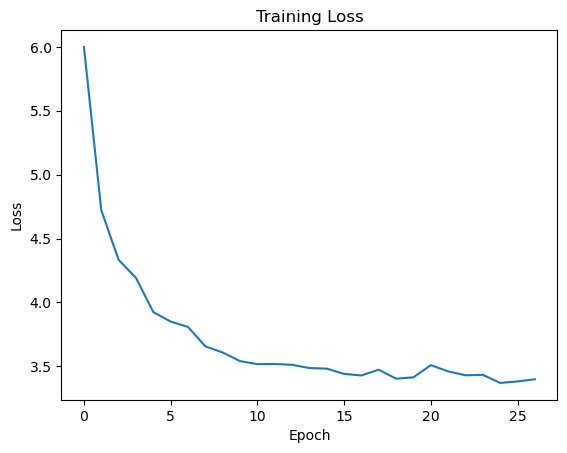

In [18]:
plt.plot(history.epoch, history.history['loss'])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.axis
plt.show()

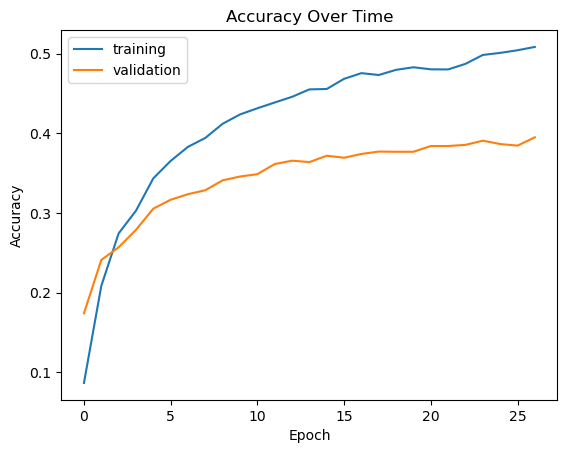

In [19]:
plt.plot(history.epoch, history.history['accuracy'], label="training")
plt.plot(history.epoch, history.history['val_accuracy'], label="validation")
plt.title("Accuracy Over Time")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Fine-tune the model

Save/load the trained weights so we don't have to retrain if we need to modify the fine-tuning.

In [20]:
model.save_weights("feature_extractor_weights")

In [21]:
_ = model.load_weights("feature_extractor_weights")

Find the layers to unfreeze:

In [22]:
# Each Inverted Residual and Linear Bottleneck block is prefixed by expanded_conv_#
# https://github.com/keras-team/keras/blob/9de24b0beac97d1ef8c34e427beb895ef791d254/keras/applications/mobilenet_v3.py#L604-L668
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 rescaling
2 Conv
3 Conv/BatchNorm
4 tf.__operators__.add
5 re_lu
6 tf.math.multiply
7 multiply
8 expanded_conv/depthwise
9 expanded_conv/depthwise/BatchNorm
10 re_lu_1
11 expanded_conv/project
12 expanded_conv/project/BatchNorm
13 expanded_conv/Add
14 expanded_conv_1/expand
15 expanded_conv_1/expand/BatchNorm
16 re_lu_2
17 expanded_conv_1/depthwise/pad
18 expanded_conv_1/depthwise
19 expanded_conv_1/depthwise/BatchNorm
20 re_lu_3
21 expanded_conv_1/project
22 expanded_conv_1/project/BatchNorm
23 expanded_conv_2/expand
24 expanded_conv_2/expand/BatchNorm
25 re_lu_4
26 expanded_conv_2/depthwise
27 expanded_conv_2/depthwise/BatchNorm
28 re_lu_5
29 expanded_conv_2/project
30 expanded_conv_2/project/BatchNorm
31 expanded_conv_2/Add
32 expanded_conv_3/expand
33 expanded_conv_3/expand/BatchNorm
34 re_lu_6
35 expanded_conv_3/depthwise/pad
36 expanded_conv_3/depthwise
37 expanded_conv_3/depthwise/BatchNorm
38 re_lu_7
39 expanded_conv_3/squeeze_excite/AvgPool
40 expanded_conv_3/squee

In [23]:
# Choose to train the top 2 blocks
for layer in model.layers[:211]:
   layer.trainable = False
for layer in model.layers[211:]:
   layer.trainable = True

In [24]:
# Recompile the model with a low training rate
# Optimizer hyperparameters taken from the training parameters used by TensorFlow team:
# https://github.com/tensorflow/models/tree/master/research/slim/nets/mobilenet#v3
# Use 1/10 learning rate
opt = keras.optimizers.RMSprop(
    learning_rate=0.002,
    rho=0.9,
    momentum=0.9,
    epsilon=2e-03,
    decay=1e-05
)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Stop when accuracy on validation set stops increasing (early stopping)
epochs = 100
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.005, patience=3, restore_best_weights=True)
history = model.fit(ds_train, epochs=epochs, validation_data=ds_validation, callbacks=[callback])

Epoch 1/100
4072/4072 [==============================] - 57s 13ms/step - loss: 4.0532 - accuracy: 0.1611 - val_loss: 2.6093 - val_accuracy: 0.3429
Epoch 2/100
4072/4072 [==============================] - 53s 13ms/step - loss: 2.2155 - accuracy: 0.4322 - val_loss: 1.8453 - val_accuracy: 0.5347
Epoch 3/100
4072/4072 [==============================] - 54s 13ms/step - loss: 1.5068 - accuracy: 0.6023 - val_loss: 1.6515 - val_accuracy: 0.5782
Epoch 4/100
4072/4072 [==============================] - 54s 13ms/step - loss: 1.0627 - accuracy: 0.7106 - val_loss: 1.4493 - val_accuracy: 0.6138
Epoch 5/100
4072/4072 [==============================] - 53s 13ms/step - loss: 0.7976 - accuracy: 0.7832 - val_loss: 1.4167 - val_accuracy: 0.6386
Epoch 6/100
4072/4072 [==============================] - 53s 13ms/step - loss: 0.5958 - accuracy: 0.8345 - val_loss: 1.4076 - val_accuracy: 0.6424
Epoch 7/100
4072/4072 [==============================] - 54s 13ms/step - loss: 0.4405 - accuracy: 0.8816 - val_loss: 1

## Learning curves

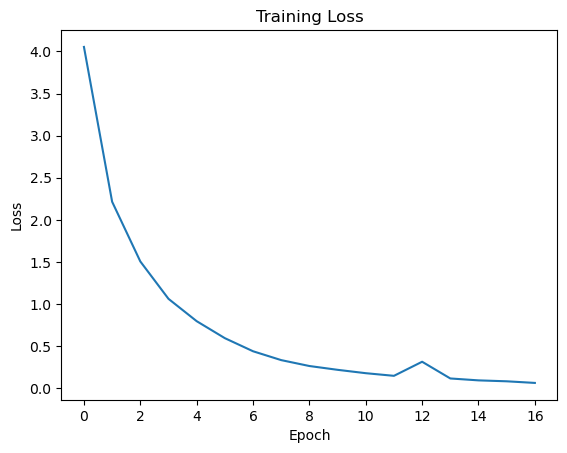

In [26]:
plt.plot(history.epoch, history.history['loss'])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

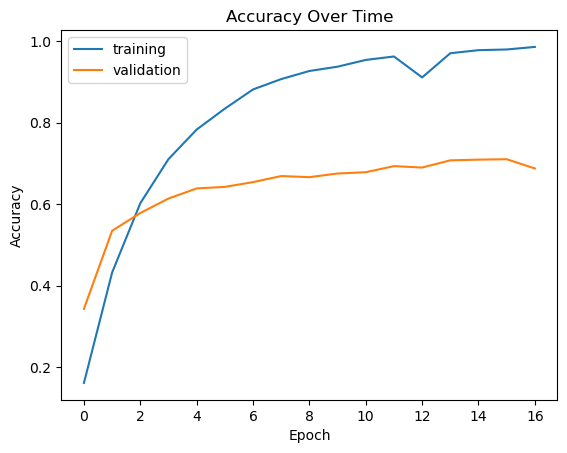

In [27]:
plt.plot(history.epoch, history.history['accuracy'], label="training")
plt.plot(history.epoch, history.history['val_accuracy'], label="validation")
plt.title("Accuracy Over Time")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Evaluate model

In [28]:
results = model.evaluate(ds_test)
print("loss, accuracy:", results)

2010/2010 [==============================] - 14s 7ms/step - loss: 1.2676 - accuracy: 0.7124
loss, accuracy: [1.2675634622573853, 0.7124378085136414]


# Save model

In [29]:
model.save("car_detection_model")